## Opesci-FD: Tensorflow integration in the outer loop

This notebook is intended a work-in-progress design document for the design of integrating TensorFlow into the outer loop within the Opesci software stack.

#### Installation
To use tikzmagic, simply clone [this](https://github.com/mkrphys/ipython-tikzmagic) repo into your `.ipython/extensions` as described in [this](http://stackoverflow.com/questions/30602433/jupyter-how-to-make-simple-illustrations) thread. Alternatively, for the least amount of pain, simply execute this line:
```
wget https://raw.githubusercontent.com/mkrphys/ipython-tikzmagic/master/tikzmagic.py -O ~/.ipython/extensions/tikzmagic.py
```

In [2]:
%load_ext tikzmagic

### Requirements and design goals

First of all let us define what the key requirements are:
* Fast execution of general Finite Difference kernels
  * Express kernel in high-level symbolic math via SymPy
  * Define spatial and temporal order to generate stencil
  * Define boundary conditions and input data
  * Generate fast and efficient code to solve system
  
* Expression and execution of FWI workflows
  * Express Forward and Adjoint models symbolically
  * Expressing FWI gradient search symbolically
  * Generate fast code for solving multiple shots in parallel
  * Generate highly parallel data pipeline for large numbers of shots

### Software Design Overview

Below is the work-in-progress component overview that describes the layers of abstractions that we should aim to build in order to decouple the overall problem definition from low-level execution and create well-defined areas for the respective experts to perform their magic. This design is by no means final and input and comments are very welcome.

The general idea defines three distinct layers:
* Symbolic layer (red): Creation and manipulation of equations and mathematical expressions in the form of uncompiled SymPy forms/expressions.
* Code-generation layer (green): Validation and compilation of SymPy expressions into some internal representation (IR) of the code in the form of ASTs (abstract syntax tree). Note that the IR is still accessible and mutable at this stage (no strings!).
* Hardware layer: Addition of hardware specific boiler plate code and platform-specific optimisation results in customised code that gets generated and compiled at the very last stage of the pipeline.

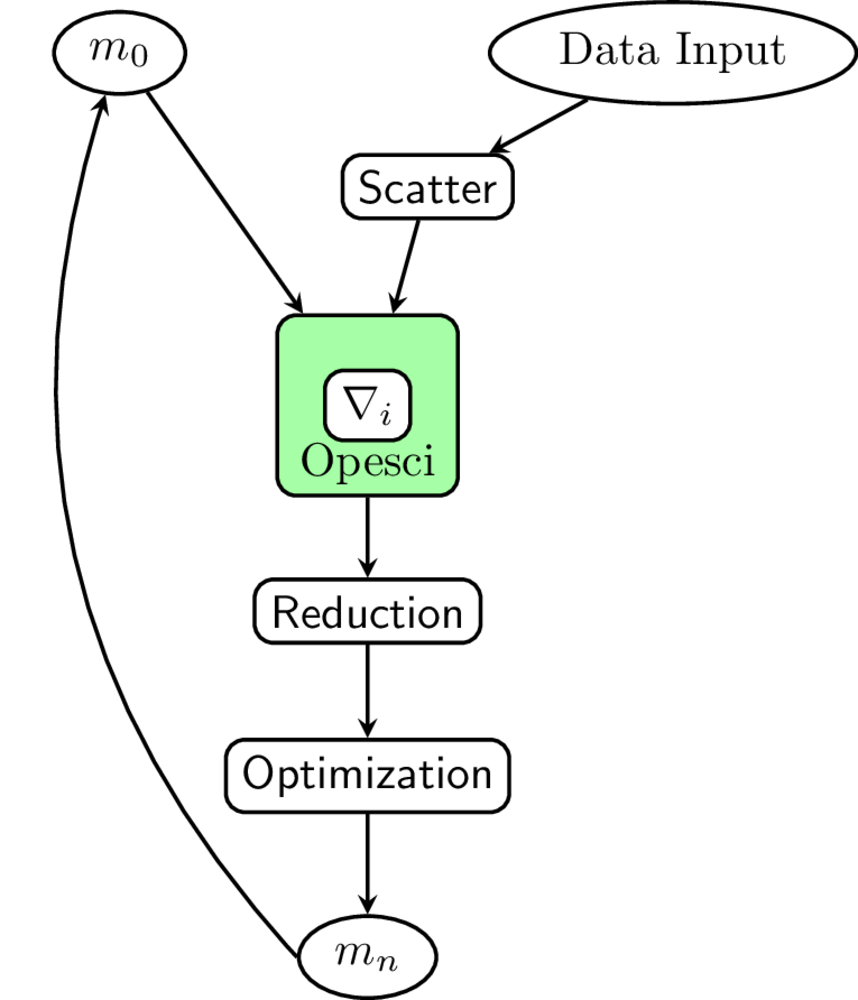

In [31]:
%%tikz -s 1000,1000

\usetikzlibrary{shapes,snakes}

%\newcommand{\boundellipse}[3]% center, xdim, ydim
%{(#1) ellipse (#2 and #3)
%}
        
%# Style definitions
\tikzstyle{line} = [draw, thick];
\tikzstyle{arrow} = [-stealth, line];
\tikzstyle{box} = [draw, thick, rectangle, rounded corners, font=\sffamily];
\tikzstyle{var} = [draw, thick, circle, minimum size=5ex];
\tikzstyle{vare} = [draw, thick, ellipse];
\tikzstyle{symbolic} = [box, minimum height=5ex, minimum width=16ex, fill=red!30]
\tikzstyle{codegen} = [box, minimum height=8ex, minimum width=16ex, fill=green!40]
\tikzstyle{hardware} = [box, minimum height=5ex, minimum width=12ex, fill=blue!30]

\node (m0) [vare] {$m_0$};
\node (datainput) [vare, right=15ex] at (m0.east) {Data Input};
\node (scatter) [box, left=3ex, below=5ex] at (datainput.west) {Scatter};
\node (opesci) [box, fill=green!35, right=9ex, below=13ex, minimum height=9ex, minimum width=9ex, label={[label distance=-3.5ex]270:Opesci}] at (m0.east) {};
\node (grad) [box, fill=white, ] at (opesci) {$\nabla_i$};
\node (reduce) [box, right=0ex, below=4ex] at (opesci.south) {Reduction};
\node (optimizer) [box, right=0ex, below=12ex] at (opesci.south) {Optimization};
\node (mn) [vare, below=5ex] at (optimizer.south) {$m_n$};

\path [arrow] (m0) -- (opesci);
\path [arrow] (datainput) -- (scatter);
\path [arrow] (scatter) -- (opesci);
\path [arrow] (opesci) -- (reduce);
\path [arrow] (reduce) -- (optimizer);
\path [arrow] (optimizer) -- (mn);
\path (mn.west) edge [arrow, bend left=30] (m0);


%\path [arrow] (waveeqn.east) -- (forward.west);
%\path [arrow] (forward.south) -- (adjoint.north);
%\path [arrow] (adjoint.south) -- (gradient.north);
%\path [arrow] (gradient.west) -- (expression.east);
%\path [arrow] (gradient.south) -- (fdsolver.north);
%\path [arrow] (expression.south) -- ([xshift=3ex]outer.north);
%\path [arrow] (custom.south west) -- ([xshift=-3ex] fdsolver.north east);